# UD-MIS via QAOA

**Software**: PennyLane <br>
**Hardware**: (1) AWS Braket Simulator-SV1, (2) IonQ

In [1]:
import pennylane as qml
# from pennylane import numpy as np
import numpy as np
from pennylane import qaoa

import networkx as nx
import matplotlib.pyplot as plt

Helper function: for Graph construction

In [2]:
def find_edges(points):
    #num_pairs = int(self.num_vertices*(self.num_vertices)*0.5)
    n = len(points)
    edges = np.zeros((n, n), dtype=bool)

    for i in range(n-1):
        x_i, y_i = points[i] # these are the x, y coordinates of the i'th vertex in the graph
        for j in range(i+1, n):
            x_j, y_j = points[j] # these are the x, y coordinates of the j'th vertex in the graph

            # calculate the distance between vertices
            dij = np.sqrt((x_i - x_j)**2. + (y_i - y_j)**2.)
            if dij <= 1.0:
                edges[i,j] = True
                edges[j,i] = True

    return edges

Problem definition

In [16]:
points = [(0.3461717838632017, 1.4984640297338632), 
         (0.6316400411846113, 2.5754677320579895), 
         (1.3906262250927481, 2.164978861396621), 
         (0.66436005100802, 0.6717919819739032), 
         (0.8663329771713457, 3.3876341010035995), 
         (1.1643107343501296, 1.0823066243402013)
        ]

In [4]:
num_vertices = 10
points = []
for i in range(num_vertices):
    points.append((np.random.rand()*np.random.randint(8), np.random.rand()*np.random.randint(8)))

In [17]:
points

[(0.3461717838632017, 1.4984640297338632),
 (0.6316400411846113, 2.5754677320579895),
 (1.3906262250927481, 2.164978861396621),
 (0.66436005100802, 0.6717919819739032),
 (0.8663329771713457, 3.3876341010035995),
 (1.1643107343501296, 1.0823066243402013)]

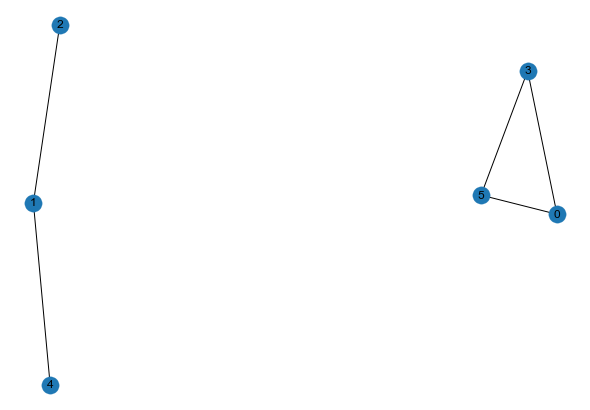

In [18]:
edges = find_edges(points)

nx_graph = nx.from_numpy_array(edges)
nx.draw(nx_graph, with_labels=True)
plt.show()

**Cost and Mixer**

In [26]:
cost_h, mixer_h = qaoa.max_independent_set(nx_graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian   (-0.5) [Z0]
+ (-0.5) [Z3]
+ (-0.5) [Z5]
+ (-0.5) [Z1]
+ (0.25) [Z2]
+ (0.25) [Z4]
+ (0.75) [Z0 Z3]
+ (0.75) [Z0 Z5]
+ (0.75) [Z1 Z2]
+ (0.75) [Z1 Z4]
+ (0.75) [Z3 Z5]
Mixer Hamiltonian   (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]
+ (1) [X4]
+ (1) [X5]


**QAOA construction**

In [27]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [28]:
wires = range(len(points))
depth = 2

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, *params)

In [29]:
dev = qml.device("default.qubit", wires=wires)
cost_function = qml.ExpvalCost(circuit, cost_h, dev)

**SGD Optimization**

In [53]:
optimizer = qml.GradientDescentOptimizer()
steps = 100
# params = [[0.5, 0.5], [0.5, 0.5]]
params = np.random.uniform(0, 2 * np.pi, (2, depth))
params

In [54]:
gd_cost = []

for i in range(steps):
    params = optimizer.step(cost_function, params)
    gd_cost.append(cost_function(params))

print("Optimal Parameters")
print(params)

Optimal Parameters
[[2.47642007 4.28608094]
 [3.33034206 4.50972266]]


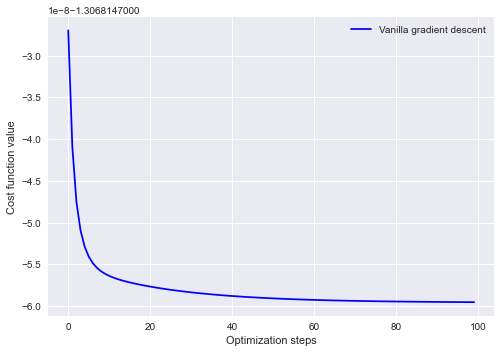

In [55]:
plt.style.use("seaborn")
plt.plot(gd_cost, "b", label="Vanilla gradient descent")

plt.ylabel("Cost function value")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()

In [56]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

In [57]:
occ_index = probs.tolist().index(max(probs))
occupation = '{0:06b}'.format(occ_index)
occ_bools = [bool(int(occ)) for occ in occupation]
occ_bools

[False, True, False, False, False, True]

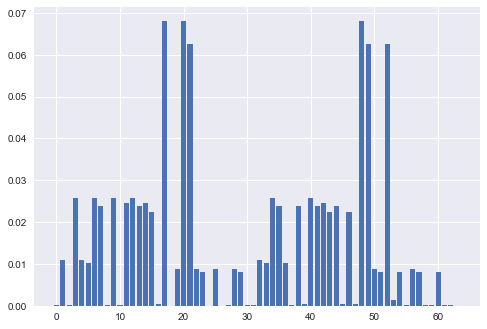

In [58]:
plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), probs)
plt.show()

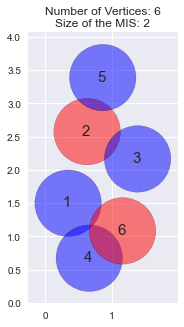

In [59]:
occ_index = probs.tolist().index(max(probs))
occ_string = '{0:06b}'.format(occ_index)
occupation = [bool(int(occ)) for occ in occupation]
# occupation = udmis.occupations
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111, aspect =1)
for i in range(len(points)):
    x,y = points[i]
    circle = plt.Circle((x,y), 0.5, edgecolor='black', alpha = 0.5,
                        facecolor='r' if occupation[i] else 'b',fill=True)
    ax.add_patch(circle)
    plt.text(x-0.08,y-0.05, i+1, fontsize=15)
plt.title('Number of Vertices: {:d}\nSize of the MIS: {:d}'.format(len(points),sum(occupation)))
ax.autoscale()
plt.show()

**SGD vs ADAM (vs Adagrad)**

In [37]:
steps = 100
init_params = params

In [34]:
gd_cost = []
opt = qml.GradientDescentOptimizer(0.01)

theta = init_params
for _ in range(steps):
    theta = opt.step(cost_function, theta)
    gd_cost.append(cost_function(theta))

In [38]:
adam_cost = []
opt = qml.AdamOptimizer(stepsize=0.01)

theta = init_params
for _ in range(steps):
    theta = opt.step(cost_function, theta)
    adam_cost.append(cost_function(theta))

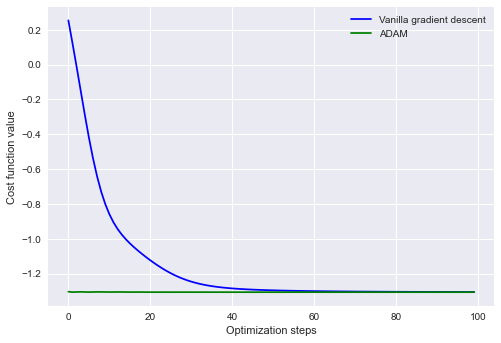

In [39]:
plt.style.use("seaborn")
plt.plot(gd_cost, "b", label="Vanilla gradient descent")
plt.plot(adam_cost, "g", label="ADAM")

plt.ylabel("Cost function value")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()